# Using Bayesian analysis to infer the characteristics of Binary Black Holes (BBHs) systems from simulated gravitational wave signals.
***
By: Luca Negri & Rebecca Ghidoni

## 0.1) Abstract
***

In this project we aim at developing methods to infere the characteristichs of BBHs from their gravitational waves signals. These signals are measured with the 3 Michelson interferometers of the LIGO-VIRGO collaboration,  the two USA ones situaded in Livingston (WA) and Hanford (LA) and one in Italy situated in Pisa.



<p float="left">
  <img src="Images/lho4s.jpg" width="100" />
  <img src="Images/llo4s.jpg" width="100" /> 
  <img src="Images/virgo_aerial_view_05.jpg" width="100" />
</p>
Gravitational waves when passing througth space change the Relative length $L/L_h$ by  ~$ 10^{-21}$, where $L_h$ is the distance during the passagge of the wave.

In the interferometers the effects amount to a difference in length in the arms of $10^{-18}$ m  over a span of 4 Km. Measuring these small changes over such a huge distance is the biggest challenge that gravitational wave astronomy has to face.

In this notebook we will face these same challanges, trying to mitigate the noise and extract the parameters of the systems. The signals that we will try to find will be simulated by us and are not the real ones, since the real wave shape at coalescence is really complex and requires methods of numerical relativity to correctly evaluate. So we will add a simpler signal that bears the same characteristic of a real one to the actual noise recived by the interferometers.


### 0.2 Import data and libraryes

In [ ]:
#Non-base packages needed to be installed in this project 

#install.packages('bspec')
#install.packages('mvtnorm')
#install.packages(psd)
#install.packages(spectral)
#install.packages(coda)
#install.packages('gridExtra')


#Importing libraries

library(signal)
library(tidyverse)
library(psd)
library(spectral)
library(bspec)
library(mvtnorm)
library(coda)
library(MASS)
library(ggplot2)
library(gridExtra)

Here we import the necessary data, found at https://www.gw-openscience.org/eventapi/

In [2]:
#names <- list.files(path = "./BBHs/Gravitational_waves/")
start_time <- substr(names,20,29)
type <- substr(names,3,4)

#Importing Data
time_s1 <- read.csv('Data/L-L1_GWOSC_4KHZ_R1-1126259447-32.txt',skip=2)[[1]]
#time_s2 <- read.csv('L-L1_GWOSC_4KHZ_R1-1126257415-4096.txt',skip=2)[[1]]

#Define time space
t <- seq(0,32,length.out=length(time_s1))

#Fundamental constants 
c <- 299792458
G <- 6.67408*10^(-11)*1.988*10^30 # G in solar masses

# Sampling frequency
fs <- 4096 


## 1.1 ) Waveform calculation 
***

Given a system of two black holes, with masses $m_1$ and $m_2$ , the main therm that determines how the gravitational wave signal evolves in time is the _chirp mass_ of the system, that is defined as 

$$
M_c = \frac{(m_1 m_2)^{\frac{3}{5}}}{(m_1 + m_2)^{\frac{1}{5}}}
$$


The first order approximation, for almost circular orbits, of the gravitational wave around the time of coalescence takes the form:

$$
h(t) = A \big{(} \frac{G M_c}{c^2} \big{)} ^{\frac{5}{4}} \big{(}\frac{5}{c \tau}\big{)}^{\frac{1}{4}} cos( \phi(\tau))
$$

where $\phi ( \tau )$ is equal to


$$
\phi (\tau) = -2 \big{(} \frac{c^3}{5 G M_c} \big{)} ^{\frac{5}{8}} + \phi _0
$$

and where $\tau$ is the time to coalescence, $\phi _0$ is the  phase of the Gravitational wave at coalascence and $A$ is a multiplicative therm therm that encapsulates all of the amplitude contributions given by the luminosity of the signal, the distance from the source, the polarization of the GW, And the antenna pattern of the interferometer .

The function calculating the waveform is `waveform1` and outputs the GW effect given the parameters $M_c$, $A$, $\phi_0$ and the time at coalescence $t_0$. The same function will be used in the simulation of the signal and during the likelyhood computation. The amplitude of the signal is a-dimensional, so $A$ has no units, $t_0$ is expressed in seconds, $\phi_0$ in radiants and $M_c$ in solar masses.

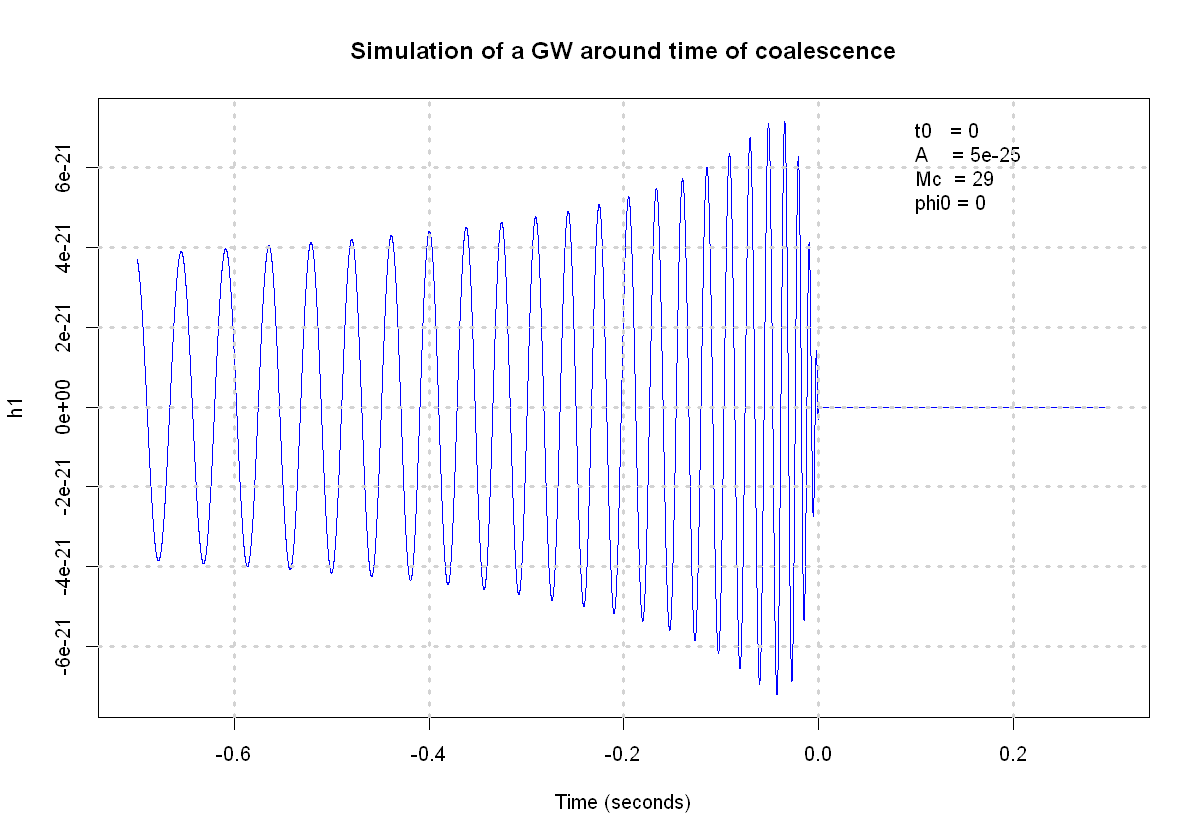

In [3]:
#Wavwform calculator
waveform1 <- function(t , Mc , A , phi0,t0 ){
    
    t <- t0-t
    sigmoide <- (1/(1+exp(-(t)*80))-0.5)*2 # Taper function


    h1 <- (Mc*G/c^2)^(5/4)*A*(t*c/5)^(-0.25)*cos(-2*(t*c^3/(5*G*Mc))^(5/8)+phi0)*sigmoide
    
    h1[is.na(h1)] <- 0 # eliminate signal where it does not exists
    return(h1)
     
}

t0 <- 0 #define time of arrival
tseries <- seq(t0-0.7,t0+0.3,length.out = fs*4)#define timespace

options(repr.plot.width = 10 ,repr.plot.heigth=10)

sim_params <- c(t0 , 5*10^(-25) , 29 , 0.0 )#prams of the GW signal

h1 <- waveform1(tseries,sim_params[3],sim_params[2],sim_params[3],t0 = sim_params[1])


plot(tseries,h1,type='l', col = 'blue',
     main='Simulation of a GW around time of coalescence',
     xlab='Time (seconds)'
    )
text_to_plot <- paste('t0   = ',t0,'\nA    = ',sim_params[2],'\nMc  = ' ,sim_params[3],'\nphi0 = ',sim_params[4],sep='')
xt <- 0.1
yt <- max(h1)
text(xt,yt,labels=text_to_plot,adj=c(0,1))
grid(lwd = 3)



This approximation usually holds pretty well rigth until $\tau$ ~ 0 , where the point mass approximation for the black holes breakes down and methods of numerical relativity have to be used in order to predict the shape of the GW. For this reason a taper function is applied to our simulated waveform rigth around the time of coalescence, in order to attenuate the effects of the function where it is not capable of producing realistic results anymore.

## 2) Likelyhood definition
***
The code and the form of the likelyhood was based on the paper [**A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals**](https://arxiv.org/pdf/1908.11170) by the LIGO-VIRGO collaboration
### 2.1) Power Spectral Density computation



The raw signal coming from the dectors is vastly dominated by noise, especially a low frequency component that's clearly visible in the data, mainly due to instability in the laser output. To analyze the GW our first aim is basically to turn this brown and complex noise into white noise cenered around 0. This is obtained by evaluating the ***Power Spectral Density*** (PSD) of the signal around the measured event and then definig an appropriate likelyhood that depends on the frequency components of the signal.

Prior to the definition, we need to properly window the signal, in order to not create aberrations in the `fft` algorithm

In [4]:
#time_s2 <- time_s2[(1024*fs):(3072*fs)] #extract a time series around the event

window <- tukeywindow(fs*4,r=0.25)#window

We calculate the PSD of the interferometer with the `welchPSD` function of the `bspec` package, that averages the data took over a a 2048 second time series centered around the event and dividing it into 4 seconds windows, that is the same length as the signal that we will try to analyze

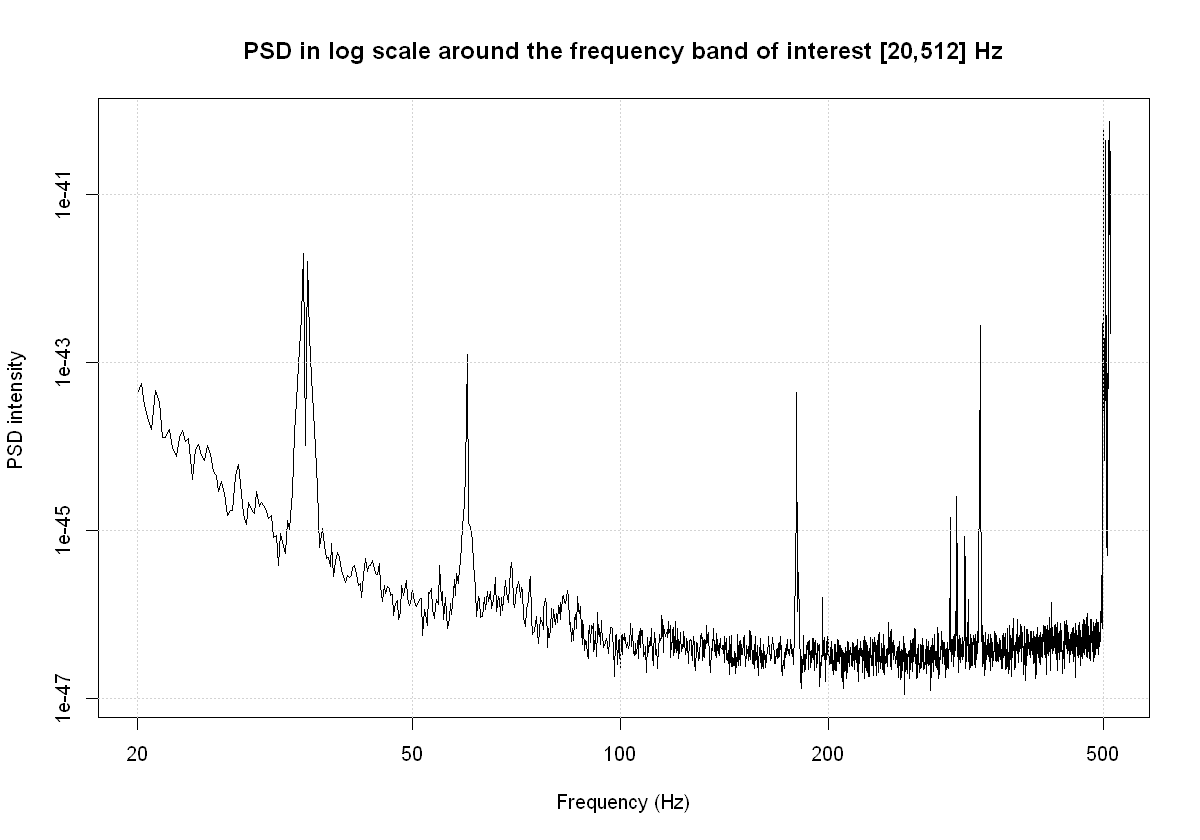

In [6]:
PSD <- welchPSD(as.ts(time_s1,frequency=fs),seglength=(fs*4-1),windowfun =tukeywindow,r = 0.25)
PSDspline <- splinefun((PSD$frequency)*fs,PSD$power)

freq_space <- PSD$frequency*fs
PSD_pow <-PSD$power/length(PSD$power) # Correct normalization

freq_mask <- freq_space>20 & freq_space<512

options(repr.plot.width = 10 ,repr.plot.heigth=10)

plot(freq_space[freq_mask],PSD_pow[freq_mask],
     type='l',log='xy',pch=15, 
    xlab='Frequency (Hz)',ylab='PSD intensity ',
    main='PSD in log scale around the frequency band of interest [20,512] Hz')
grid(equilogs=F)
#axis(1, at=log10Tck('x','major'), tcl= 0.2) # bottom


### 2.2 ) Definition of the likelyhood function.

In bayesian statistichs, the likelyhood function used to infere a signal polluted by gaussian white noise is

$$
p(\mathbf{d}|\theta) = \frac{1}{\sqrt{2 \pi \sigma ^ 2}} exp \big{(} - \frac{1}{2}  \frac{(\mathbf{d}- \mu(\theta) )^2}{\sigma^2} \big{)}
$$

Where $\sigma$ is the standard deviation , $d$ is the data that we got, and $\mu(\theta)$ is the waveform, dependent on the parameters $\theta$, that we want to look for.

In our case the noise is not white, but it's strongly frequency dependent, so we need to define a different likelyhood that takes this into account. The new likelyhood will be based around the is the _noise weigthed inner product_, defined, for two signal $\mathbf{a}$ and $\mathbf{b}$ as

$$
(\mathbf{a} | \mathbf{b} ) = 2 \int^{\infty}_0 \frac{\tilde a(f) \tilde b^*(f) + \tilde a^*(f) \tilde b(f) }{S_n (f)}
$$

where $S_n$ is the noise spectral density, that we previously computed and the "~" indicates that we are dealing with signals in the frequency domain .
Then we can define the function $\chi ^ 2 (\mathbf{d},\mu(\theta)) = (\mathbf{r}|\mathbf{r})$, where $\mathbf{r}$ is the  _residual_  $\mathbf{r} = \mathbf{d} - \mu(\theta)$.
Finally the likelyhood will take the form 


$$
p(\mathbf{d}|\theta) = \frac{1}{\sqrt{2 \pi det(C)}} exp \big{(}-\frac{1}{2} \chi ^2(\mathbf{d},\mu(\theta) )  \big{)}
$$

where C is the _noise correlation matrix_ , which is diagonal in the Fourier domain. 

To make the avaluation of this expression more managable we choose to work with the log likelyhood instead, where, ignoring all of the additive constants not dependent on the signal, we get

$$
log( p (\mathbf{d}|\mu(\theta)) = -\frac{1}{2}(\mathbf{d}-\mu(\theta)|\mathbf{d}-\mu(\theta))
$$





Here we plot the _whitened data_ by removing the noise PSD from the signal, this functions are only for visual purposes and are not used in the inference part. 

In [7]:
whitener2 <- function(strain,psd,dt){
    
    N <- length(strain)
    hf <- fft(strain)/N#[1:(N*0.5)]
    
    norm <- 1/sqrt(1/(dt*2))    
    white_hf <- hf / psd * norm
    
    return(white_hf)

}

bandpass <- function(strain,fband,fs){
    

    nyq <- 0.5*fs

    fband <- fband/nyq

    bf <- butter(4,c(fband[1],fband[2]),type='pass')
    
    norm <- sqrt(fband[2]-fband[1])
    
    filtered <- filtfilt(bf,strain)/norm
    return(filtered)
    
}

scal_prod <- function(a,b,PSD,df,return_sum=T){
    
    if (return_sum) {df*sum((a*Conj(b) + b*Conj(a))/PSD)}
    else {((a*Conj(b) + b*Conj(a))/PSD)*df}
    
}

In [10]:
t1 <- 0 
t2 <- 4
noise_series <- time_s1[(fs*t1):(fs*t2-1)] #extraction of the noise from the raw data

times <- seq(0,4,length.out=length(noise_series))

sim_params <- c(3.0 , 8*10^(-26) , 28.6 , 3.14 ) # parameters for this simulation

simulated_wave <- waveform1(times,sim_params[3],sim_params[2],sim_params[3],t0 = sim_params[1])

signal <- noise_series + simulated_wave # definition of the signal as noise + waveform

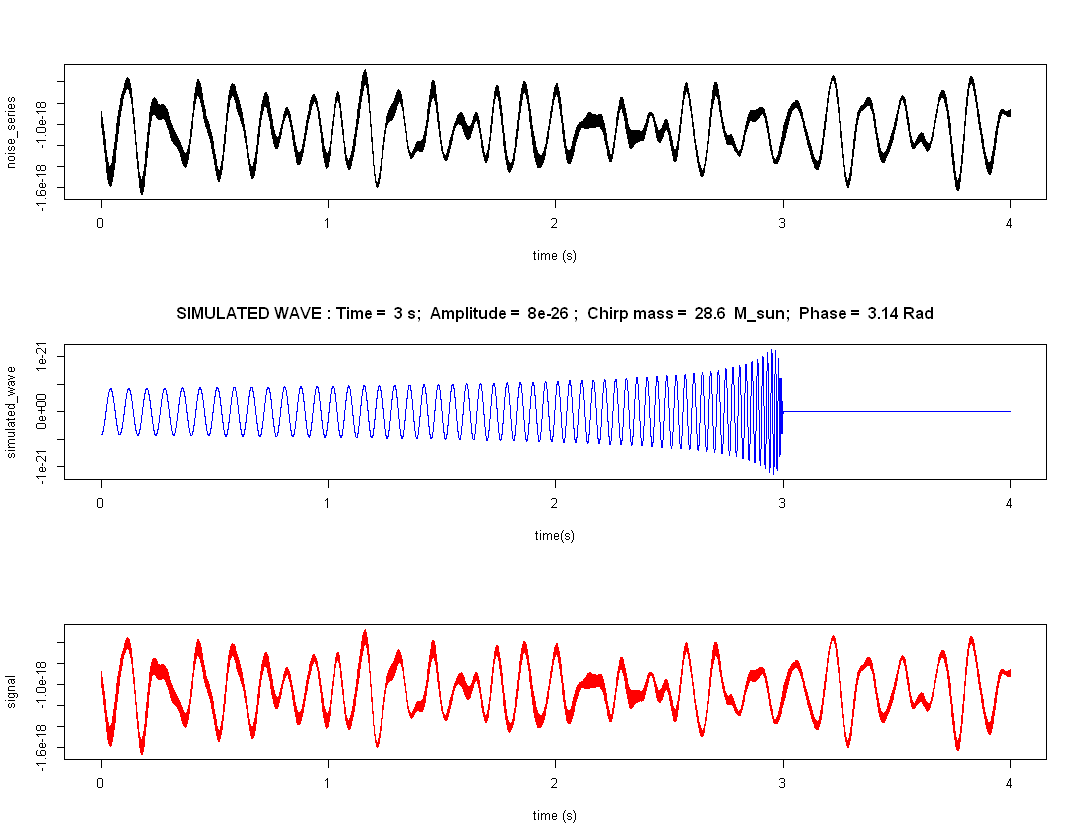

In [11]:
p_area <- matrix(c(1,1,2,2,3,3),nrow=3,ncol=2,byrow = TRUE)
layout (p_area)     
options(repr.plot.width = 9 ,repr.plot.heigth=9)



plot(times,noise_series,type='l',col = 'black',xlab='time (s)')
par <- paste('SIMULATED WAVE : Time = ',sim_params[1],'s;  Amplitude = ',sim_params[2],';  Chirp mass = ',sim_params[3],' M_sun;  Phase = ',sim_params[4],'Rad')
plot(times,simulated_wave,type='l',col = 'blue',xlab='time(s)', main=par)
plot(times,signal,type='l',col = 'red',xlab='time (s)')
box()

legend('bottom',legend=c("Noise series", "Simulated wave", "Signal"),
       fill=c('black', 'blue', 'red'),
       horiz = T, inset=c(0,-1), xpd=NA)

As we can see the amplitude of our wave is 3 orders of magnitude smaller than the noise from the detector, but it's possible to see the waveform over the noise by appling the withening functions

Warning message in signal * window:
"longer object length is not a multiple of shorter object length"Warning message in simulated_wave * window:
"longer object length is not a multiple of shorter object length"

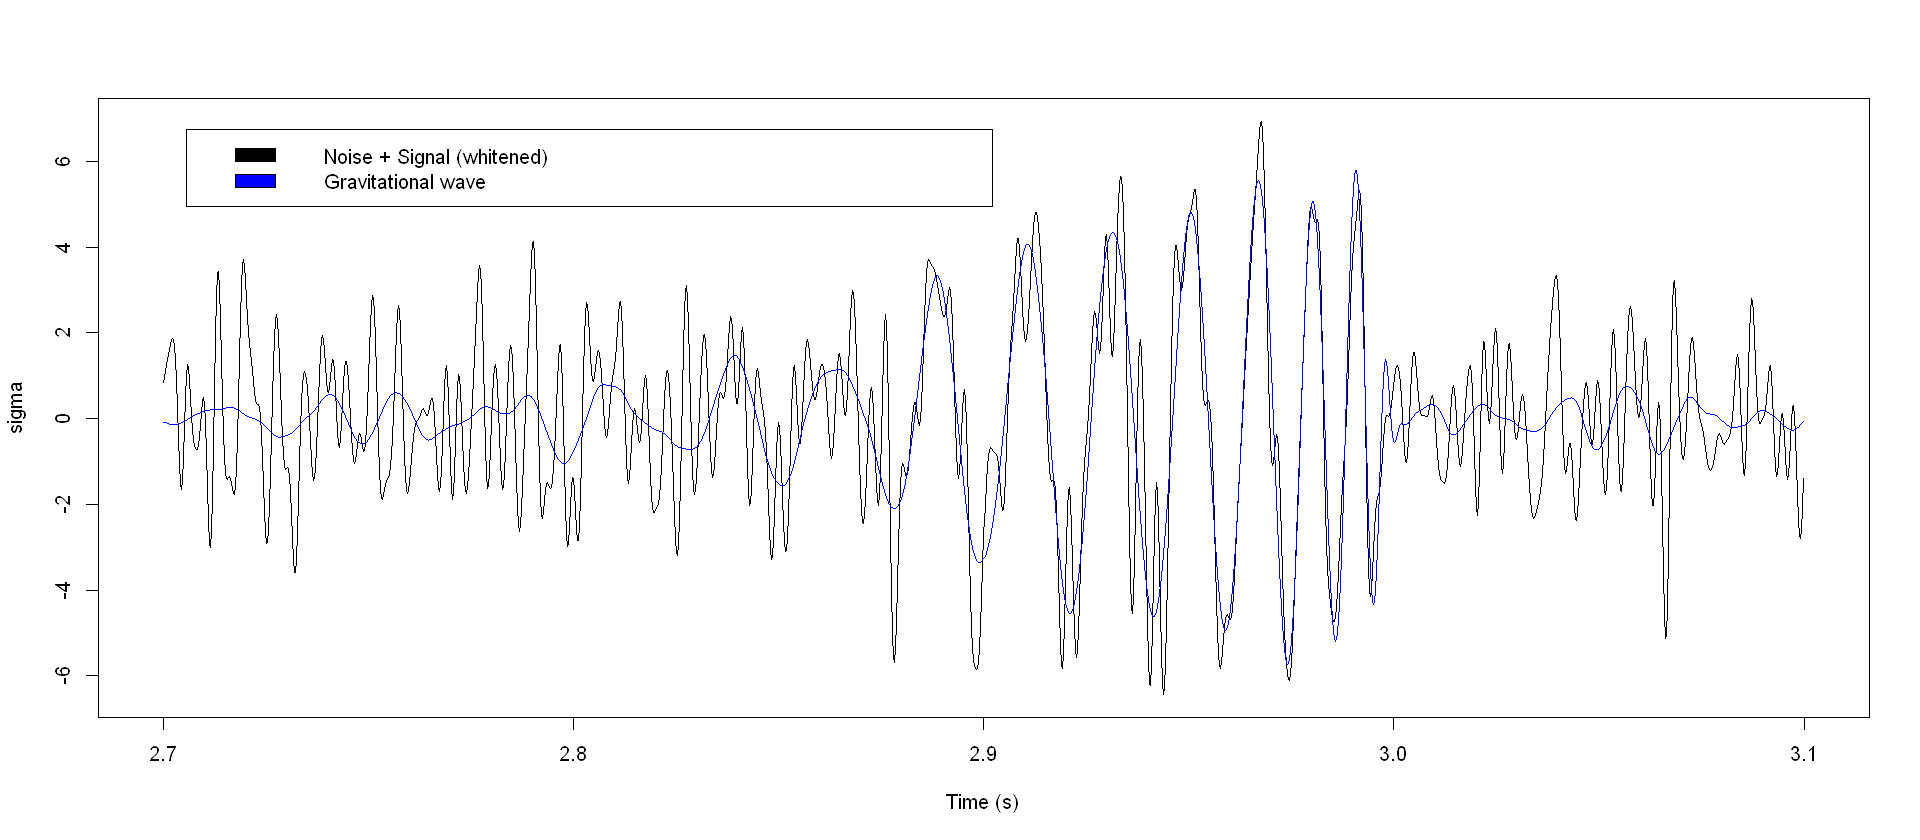

In [14]:
white_signal <- Re(fft(whitener2(signal*window,sqrt(c(PSD_pow,rev(PSD_pow))),1/4096),inverse=T))
white_signal <- bandpass(white_signal,c(35,350),fs)
time_mask <- times>2.7 & times<3.1
options(repr.plot.width = 16 ,repr.plot.heigth=6)

plot(times[time_mask],white_signal[time_mask],type='l',ylab='sigma',xlab='Time (s)')

white_signal <- Re(fft(whitener2(simulated_wave*window,sqrt(c(PSD_pow,rev(PSD_pow))),1/4096),inverse=T))
white_signal <- bandpass(white_signal,c(35,350),fs)
#sim_wave_bndpss <- bandpass(simulated_wave,c(35,350),fs)
lines(times[time_mask],white_signal[time_mask],col='blue')#[(4096*3-1000):(4096*3+500)],type='l')

legend('topleft',inset = 0.05,c('Noise + Signal (whitened)','Gravitational wave'),fill = c('black','blue'))

## 3) Definition of the priors
***

For each of the 4 parameters that we want to infere, we choose a  different prior, sutable to the prior knowledge that we have for the parameter

### 3.1) Time of coalescence prior:

The LIGO-virgo fundation provides the detected merger time for each one of the signals ($t_{LV}$) , so we choose to use a narrow flat prior around the time of coalescence, of about 0.1 second before and after the suspected time.

$$
log(  P(t_0)   ) =   \left\{
    \begin{array}{l}
      0   \text{  if  } t_{LV}-0.1<t_0<t_{LV}+0.1\\
      -\infty \text{ otherwise}
    \end{array}
  \right.
$$

### 3.2) Amplitude prior:

For $P(A)$ we choose to adopt a flat prior, but this time we gave it no upper limit and we tried to make the probability go to 0 as the amplitudes nears 0, with the help of a sigmoid function.

### 3.3) Chirp mass prior:

For the chirp mass we chose to adopt a prior that reflects the observation that have been measured so far. Since the distribution of the chirp masses observed by the collaboration does neither follow a Gaussian or a Student-t distribution, we chose to calculate the distribution density of the chirp masses got so far and use that as a prior, in the following cell is possible to see this calculation. To extend this distribution to every real value, we defined a spline function that interpolated the prior results.

### 3.4) Phase at $t_0$ prior

Since the phase at coalescence is essentially random, we chose a flat prior for this variable as well.

$$
log(  P(\phi_0)   ) =   \left\{
    \begin{array}{l}
      0   \text{  if  } 0<\phi_0<2pi\\\
      -\infty \text{ otherwise}
    \end{array}
  \right.
$$





Also we imposed that no variable could be negative, since the results could be aphisical.

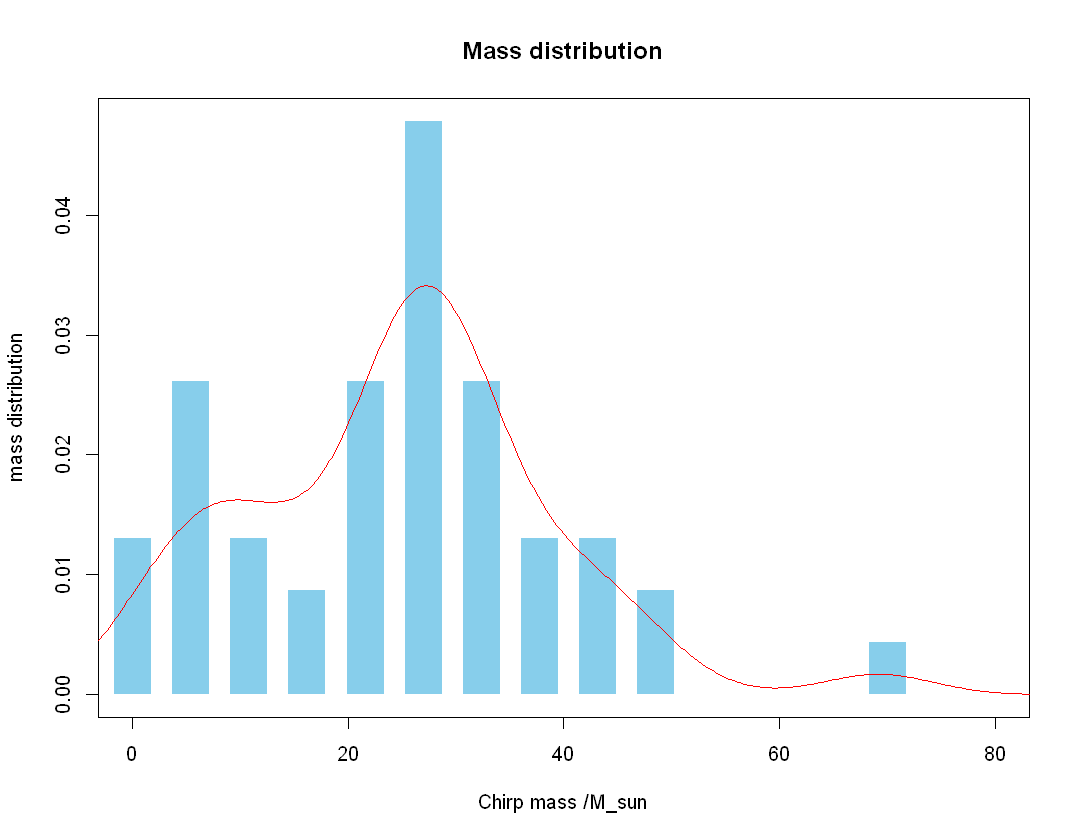

In [410]:
library('MASS')
#names <- list.files(path = "./BBHs/Gravitational_waves/")
#start_time <- substr(names,20,29)
#start_time <- strtoi(start_time)

#type <- substr(names,3,4)

#BBHs = list( names,type,start_time)

#names(BBHs) <- c("Name", "Type", "Start")

#GWs <- data.frame(BBHs)

#GWs <- GWs[order(GWs$Start),]

#events <- unique(start_time)

Mass <- c(28.6,15.2,8.9, 21.4,7.9,35.4,24.9,24.1,
          1.186,26.5,29.2,18.3,13.3,24.6,33.0,31.2,
          31.0,1.44,2.4,30.2,14.6,21.6,28.5,26.6,
          44.5,69.2,32.1,24.3,49.1,38.3,24.8,40.3,
          42.7,8.5,13.2,23.5,8.9,28.6,8.6,29.5,27.3,
          6.09,25.0,13.3,30.9,44.3,25.3,5.8,35.8,8.5)

Event <- c(1126259462.4,1128678900.4,1135136350.6,1167559936.6,1180922494.5,
           1185389807.3,1186302519.8,1186741861.5,1187008882.4,1187058327.1,
           1187529256.5,1238782700.3,1239082262.2,1239168612.5,1239198206.7,
           1239917954.3,1240164426.1,1240215503.0,1240327333.3,1240944862.3,
           1241719652.4,1241816086.8,1241852074.8,1242107479.8,1242315362.4,
           1242442967.4,1242459857.5,1242984073.8,1243533585.1,1245035079.3,
           1245955943.2,1246048404.6,1246487219.3,1246527224.2,1246663515.4,
           1247608532.9,1247616534.7,1248242632.0,1248331528.5,1248617394.6,
           1248834439.9,1249852257.0,1251009263.8,1251010527.9,1252064527.7,
           1252150105.3,1252627040.7,1253326744.8,1253755327.5,1253885759.2)



#names(Mass) = events
GWs$Mass <- Mass[GWs$Start]
GWs$Event <- Event[GWs$Start]
#row.names(GWs)<-1:nrow(GWs)
l=15
a <-hist(unique(GWs$Mass),breaks = seq(0,max(GWs$Mass),l=l),plot=F)


x=seq(0,70,length.out = 14)

area=sum(a$counts)*70/14

plot(x,a$counts/area,xlim=c(0,80),type='h',lwd=30,col='skyblue',lend=1,main='Mass distribution',
    xlab='Chirp mass /M_sun',ylab='mass distribution')






D<-density(unique(GWs$Mass))

lines(D,col='red')

In [390]:
#Defining the priors
prior.t0   <- function(t0,t0init=3,delta=0.1){
    if (abs(t0-t0init)<delta) 0
    else -Inf
}
prior.phi0 <- function(phi0){
    if (abs(phi0-pi)<pi) 0
    else -Inf  
}

prior.A <- function(A){
     0   
}

prior.A2 <- function(A){
    if (A<0){return(-Inf)}
    A <- A*1e25
    return(log( (1/(1+exp(-(A)*20))-0.5)*2))#1/(1+exp(-(A)*80))*0.5 -2
    
    
}


prior.Mc <- splinefun(D$x,D$y)


priors <- c(prior.t0,prior.A2,prior.Mc,prior.phi0)




In [391]:
#definition of the log_likelyhood
log_likel_real2 <- function(theta,obsdata,PSD_pow,PSD_freq,priors){
    
    #assign parameters
    t0   <- theta[1]
    A    <- theta[2]
    Mc   <- theta[3]
    phi0 <- theta[4]
    
    #check if negative
    if((t0<0)||(A<0)||(Mc<0)||(phi0<0)){return (c(-Inf,0))}
    
    #evaluate priors and check if suitable
    pri.t0   <- priors[[1]](t0)
    pri.A    <- priors[[2]](A)
    pri.Mc   <- log(priors[[3]](Mc))
    pri.phi0 <- priors[[4]](phi0)
    
    prior_Machain <- sum(c(pri.t0,pri.A,pri.Mc,pri.phi0))
    
    if (prior_Machain==(-Inf)) return(c(0,-Inf))
    
    
    
    freq_space <- PSD_freq*4096
    freq_mask  <- freq_space>20 & freq_space<512 #define the interesting frequency space
    length_freq<- length(freq_space)
    #freq_space <- freq_space[freq_mask]
    
    df    <- freq_space[2]
    times <- seq(0,4,length.out=length(obsdata))
    dt    <- times[2]



    hs    <- waveform1(times,Mc,A,phi0,t0)*window#simulation of a signal
    #hsf   <- fft(hs)[1:length_freq]/length(obsdata)
    #dataf <- fft(obsdata*window)[1:length_freq]/length(obsdata)
    resid <- obsdata-hs
    resid_freq <- fft(resid*window)[1:length_freq]/length(obsdata)
    resid_freq <- resid_freq[freq_mask]
    
    if(0.001>runif(1,0,1)){message('itering')}# random print


    return(c( Re(-0.5*scal_prod(resid_freq,resid_freq,PSD_pow[freq_mask],df) ),prior_Machain )) #log likel evaluation


    
    
}

## 4) Markov Chain Monte Carlo methods to infere  parameters.

To infere the posterior parameters we choose to implement a Markov Chain Monte Carlo methods with the Metropolis algorithm.
The function `metrop` defined in the cell below does performs the actual algorithm. this function can be found at https://github.com/ehalley/PBI/blob/master/PBI_scripts/metropolis.R




In [471]:
metrop <- function(func, thetaInit, Nburnin, Nsamp, sampleCov, verbose, 
                   demo=FALSE, ...) {

  Ntheta   <- length(thetaInit)
  thetaCur <- thetaInit
  funcCur  <- func(thetaInit, ...) # log10
  funcSamp <- matrix(data=NA, nrow=Nsamp, ncol=2+Ntheta) 
  # funcSamp will be filled and returned
  nAccept  <- 0
  acceptRate <- 0
  if(demo) {
    thetaPropAll <- matrix(data=NA, nrow=Nsamp, ncol=Ntheta)
  }
  
  for(n in 1:(Nburnin+Nsamp)) {

    # Metropolis algorithm. No Hastings factor for symmetric proposal
    if(is.null(dim(sampleCov))) { # theta and sampleCov are scalars
      thetaProp <- rnorm(n=1, mean=thetaCur, sd=sqrt(sampleCov))
    } else {
      thetaProp <- rmvnorm(n=1, mean=thetaCur, sigma=sampleCov, 
                           method="eigen")
    }
    funcProp  <- func(thetaProp, ...) 
    logMR <- sum(funcProp) - sum(funcCur) # log10 of the Metropolis ratio
    #cat(n, thetaCur, funcCur, ":", thetaProp, funcProp, "\n")
    if(logMR>=0 || logMR>log(runif(1, min=0, max=1))) {
      thetaCur   <- thetaProp
      funcCur    <- funcProp
      nAccept    <- nAccept + 1
      acceptRate <- nAccept/n
    }
    if(n>Nburnin) {
      funcSamp[n-Nburnin,1:2] <- funcCur
      funcSamp[n-Nburnin,3:(2+Ntheta)] <- thetaCur
      if(demo) {
        thetaPropAll[n-Nburnin,1:Ntheta] <- thetaProp
      }
    }

    # Diagnostics
    if( is.finite(verbose) && (n%%verbose==0 || n==Nburnin+Nsamp) ) {
      s1 <- noquote(formatC(n,          format="d", digits=5, flag=""))
      s2 <- noquote(formatC(Nburnin,    format="g", digits=5, flag=""))
      s3 <- noquote(formatC(Nsamp,      format="g", digits=5, flag=""))
      s4 <- noquote(formatC(acceptRate, format="f", digits=4, width=7, 
                            flag=""))
      cat(s1, "of", s2, "+", s3, s4, "\n")
    }

  }

  if(demo) {
    return(list(funcSamp=funcSamp, thetaPropAll=thetaPropAll))
  } else {
    return(funcSamp)
  }
 
}

## 5) Running the Markov chains
### 5.1) Using high amplitude signal

The simulations we gave has similar parameters to GW150914, the first ever gravitational waves recorded. The sensor noise is also taken from a time around that observation.

Here is the code that runs the markov chain. we gave 1e5 iterations with 1e4 for the burn-in, the $\sigma$ parameters have been chosen to allow the chain to span the entire parameter range

In [ ]:
thetaInit <- c(3.1,10^{-26},40,1.14) 

sampleCov <- diag(c(0.01,10^{-26},3,1)^2)

all_samp <- metrop(func=log_likel_real2,thetaInit = thetaInit,
                   Nburnin=1e4 , Nsamp= 1e5 , sampleCov = sampleCov, verbose = 1e3
                   ,obsdata=signal,PSD_pow=PSD_pow,PSD_freq = PSD$frequency,
                   priors=priors)

Here are displayed the results from the markov chains. we decided to plot each parameter density, the autocorrelation and the markov chain path. on the density plot we can see the Maximum Likelyhood extimation, the 95 % credibility interval and as a black line the actual parameters of the simulated wave by us.

In [474]:
CLfunc <- function(p,sum,cl) {
            for(i in 1:(length(sum)-1)){
                cl1 <- (1-cl)/2
                cl2 <- cl+ cl1
                if ( (sum[i+1]>= cl1) & (sum[i] <= cl1)) {
                    x1 <- (p[i]+p[i+1])/2}
                if ( (sum[i+1]>= cl2) & (sum[i] <= cl2)) {
                    x2 <- (p[i]+p[i+1])/2}            
            }
    return(c(x1,x2))}

plott<-function(n){

    p_area <- matrix(c(1,1,1,1,2,2,1,1,1,1,3,3),nrow=2,ncol=6,byrow = TRUE)
    layout (p_area)
    
    #Density plot
    den <-density(all_samp[,i])
    y<- (den$y)/sum(den$y)
    plot(den$x,y,main=main[i-2],type='l',ylab='Density',xlab = lab[i-2],cex.main=3)
    cl <- CLfunc(den$x,cumsum(y),0.95)
    a <- which(den$x > cl[[1]])[1]
    b <- which(den$x > cl[[2]])[1]-1
    polygon(den$x[(a-1):(b+1)], c(0,y[a:b],0), col='grey', density=50, lwd=0.7)
    v=format(den$x[which.max(y)],digits=4)
    h=y[which.max(y)]
    abline(v=v,col='blue1',lwd=2,lty=3)
    abline(h=h,col='blue1',lwd=2,lty=3)
    points(y=h,x=v,col='red',pch = 16,cex = 2.5)
    grid()
    text(min(den$x)*0.82+max(den$x)*0.18,0.55*h,paste('MLE = ',v),cex=2)
    text(min(den$x)*0.82+max(den$x)*0.18,0.5*h,paste('95% CI  = [',format(den$x[(a-1)],digits=4),',',format(den$x[(b+1)],digits=4),']'),cex=2)
    
    abline(v=sim_params[i-2],lty='dashed',col='black')
    
    #Autocorrelation plot
    plot(autocorr(as.mcmc(all_samp[,i]),my_lags),main='AUTOCORRELATION',xlab='Lags',ylab='',cex.main=1)
    grid()
    
    #Markov chain plot
    plot(all_samp[,i],type='l',main='MARKOV CHAIN',ylab=lab[i-2],cex.main=1)
    grid()
    abline(h=density(all_samp[,i])$x[which.max(density(all_samp[,i])$y)],col='red')}

    

lab <-c('Time (s)','Amplitude','Chirp mass (M_sun)','Phase (Rad)')
main <- c('TIME','AMPLITUDE','CHIRP MASS','PHASE')
my_lags <- seq(0,1e5,1000)

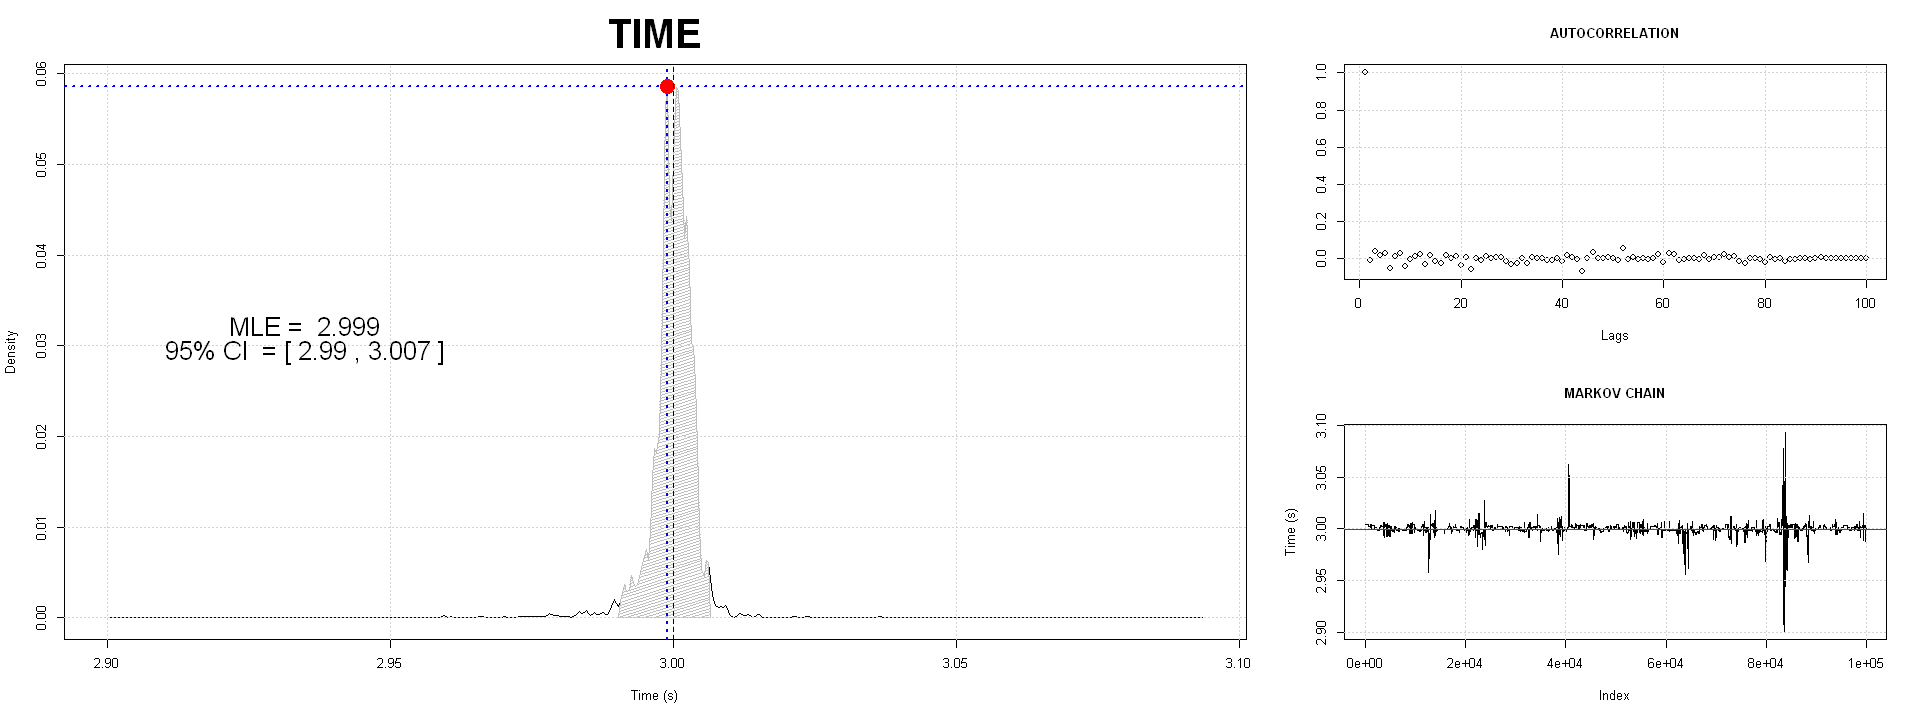

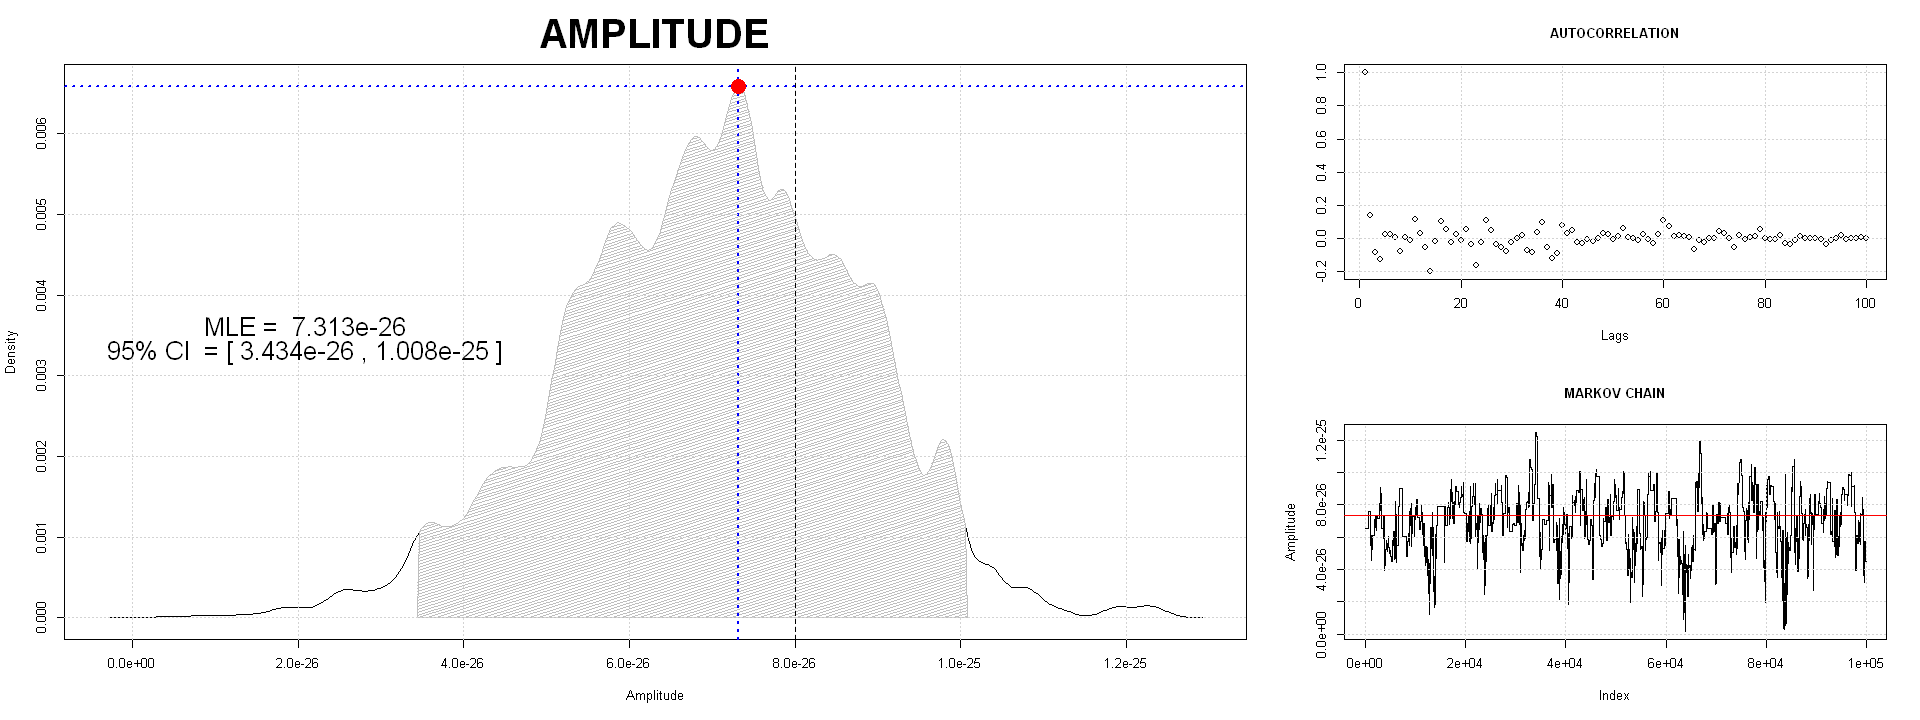

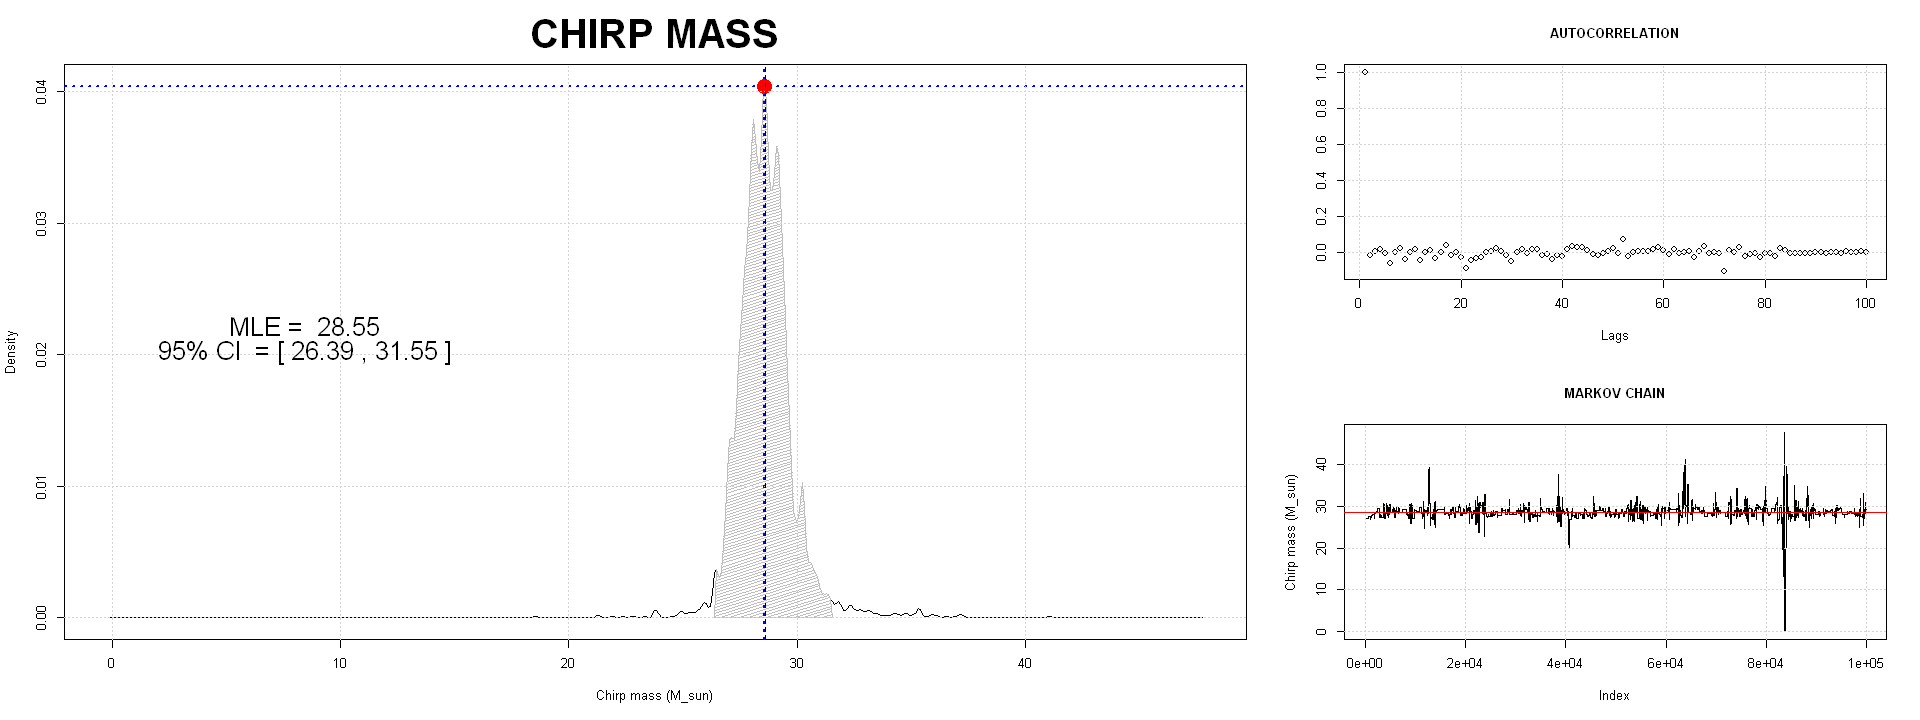

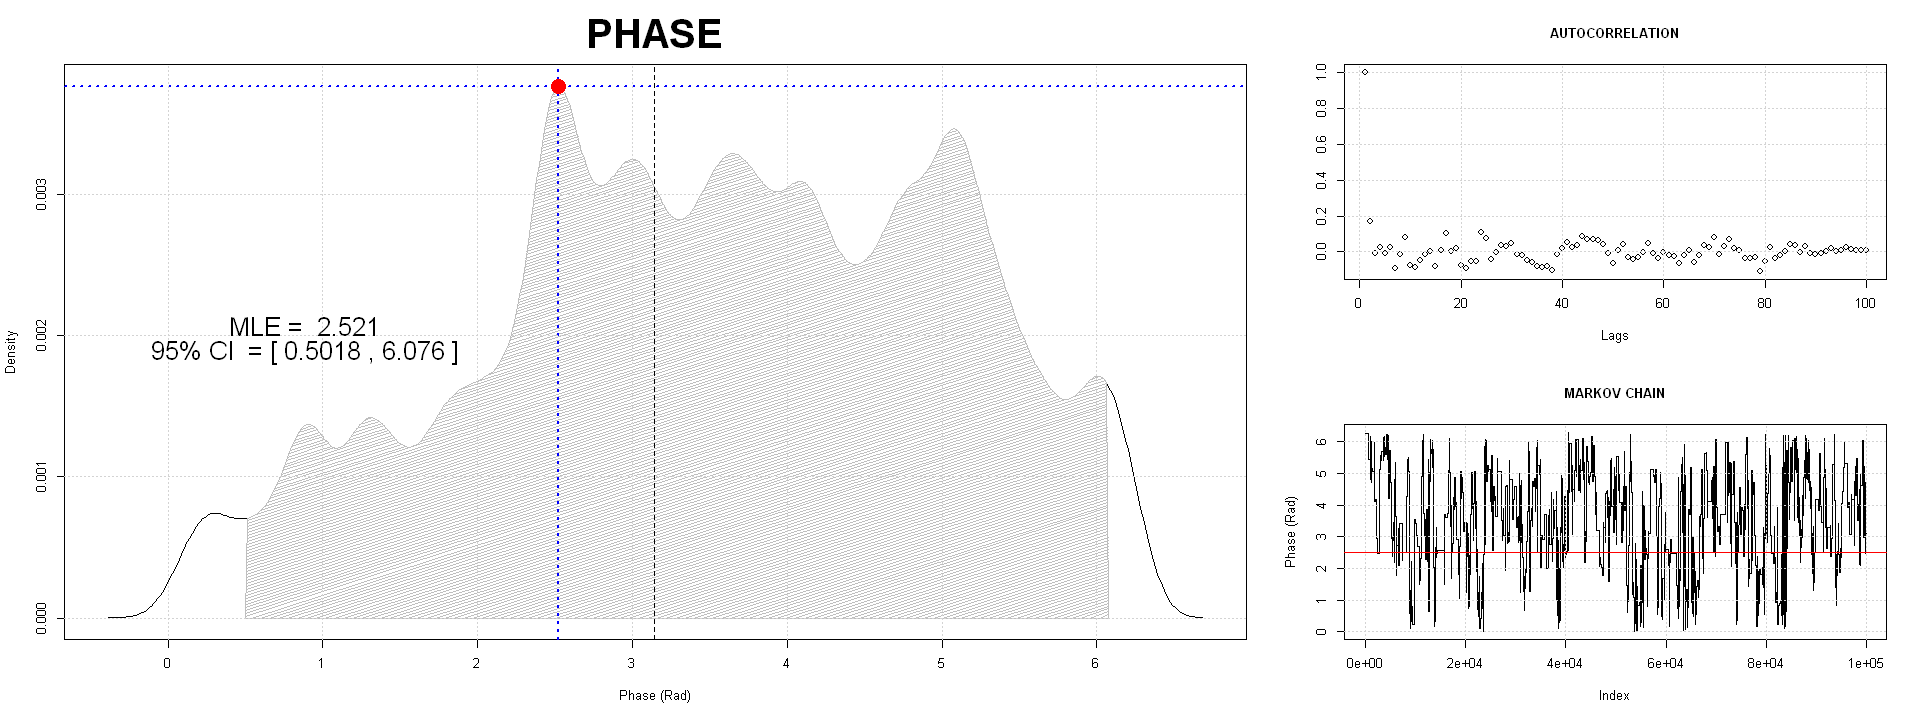

In [475]:
options(repr.plot.width=16, repr.plot.height=6)
for (i in 3:6){plott(i)}

Here we show a collection of heat maps that display all of the possible combinations of the 6 parameters

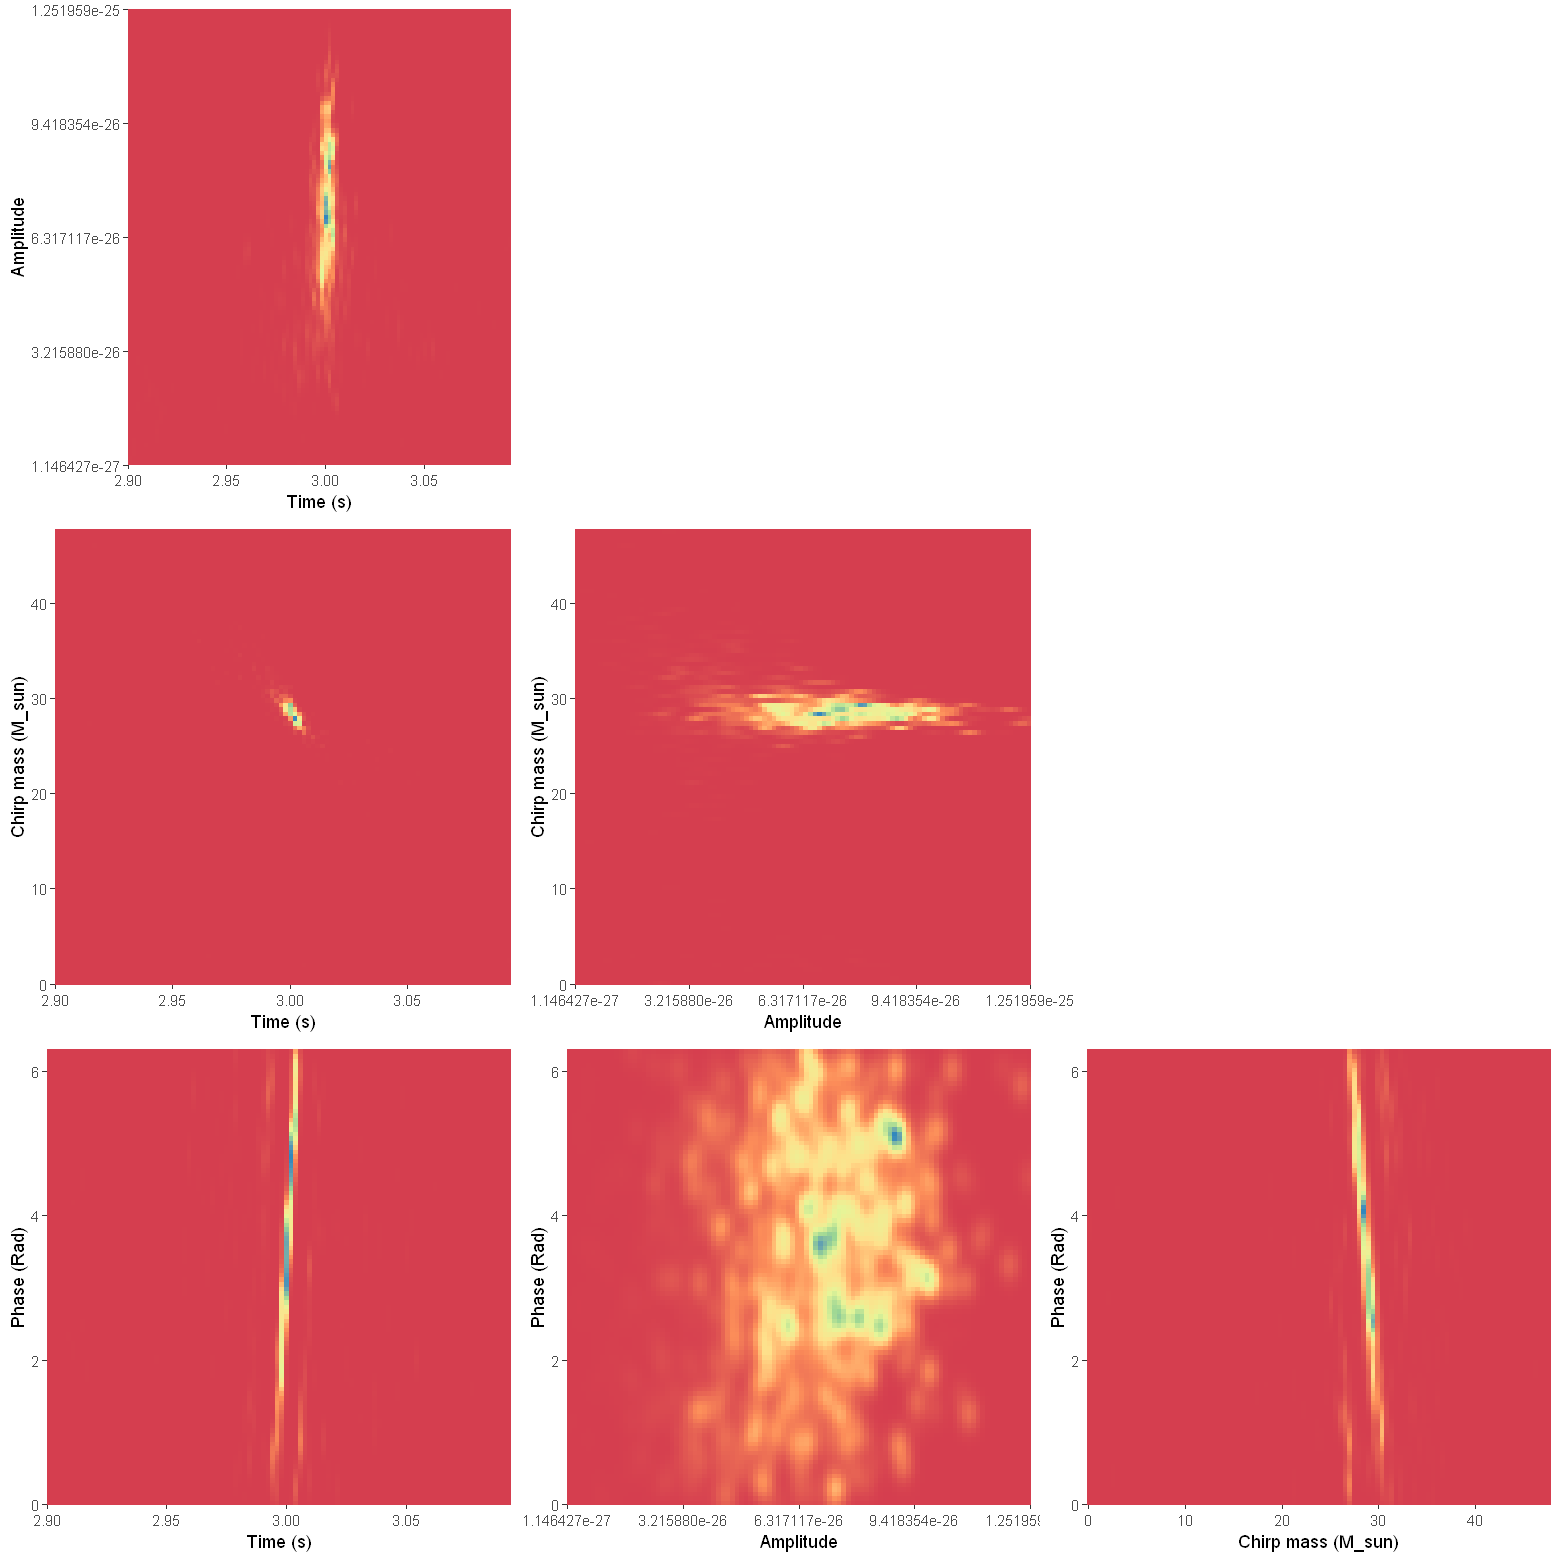

In [476]:
plot3<-function(i,j){
    
    c <- data.frame( x=all_samp[,i], y=all_samp[,j] )

    k<-ggplot(c, aes(x=x, y=y) ) +
        stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE ) +
        scale_fill_distiller(palette= "Spectral", direction=1) +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(expand = c(0, 0)) +
        theme(legend.position='none')+
        xlab(lab[i-2])+
        ylab(lab[j-2])
        
    return (k)
    
}

p1<-plot3(3,4)
p2<-plot3(3,5)
p3<-plot3(3,6)
p4<-plot3(4,5)
p5<-plot3(4,6)
p6<-plot3(5,6)

options(repr.plot.width=13, repr.plot.height=13)
p_area <- matrix(c(1,1,NA,NA,NA,NA,2,2,4,4,NA,NA,3,3,5,5,6,6),nrow=3,ncol=6,byrow = TRUE)
grid.arrange(p1,p2,p3,p4,p5,p6,layout_matrix=p_area)

## 5.2 Lower amplitude wave
Now we will try the same analysis seen above but with waves of lower amplitude.

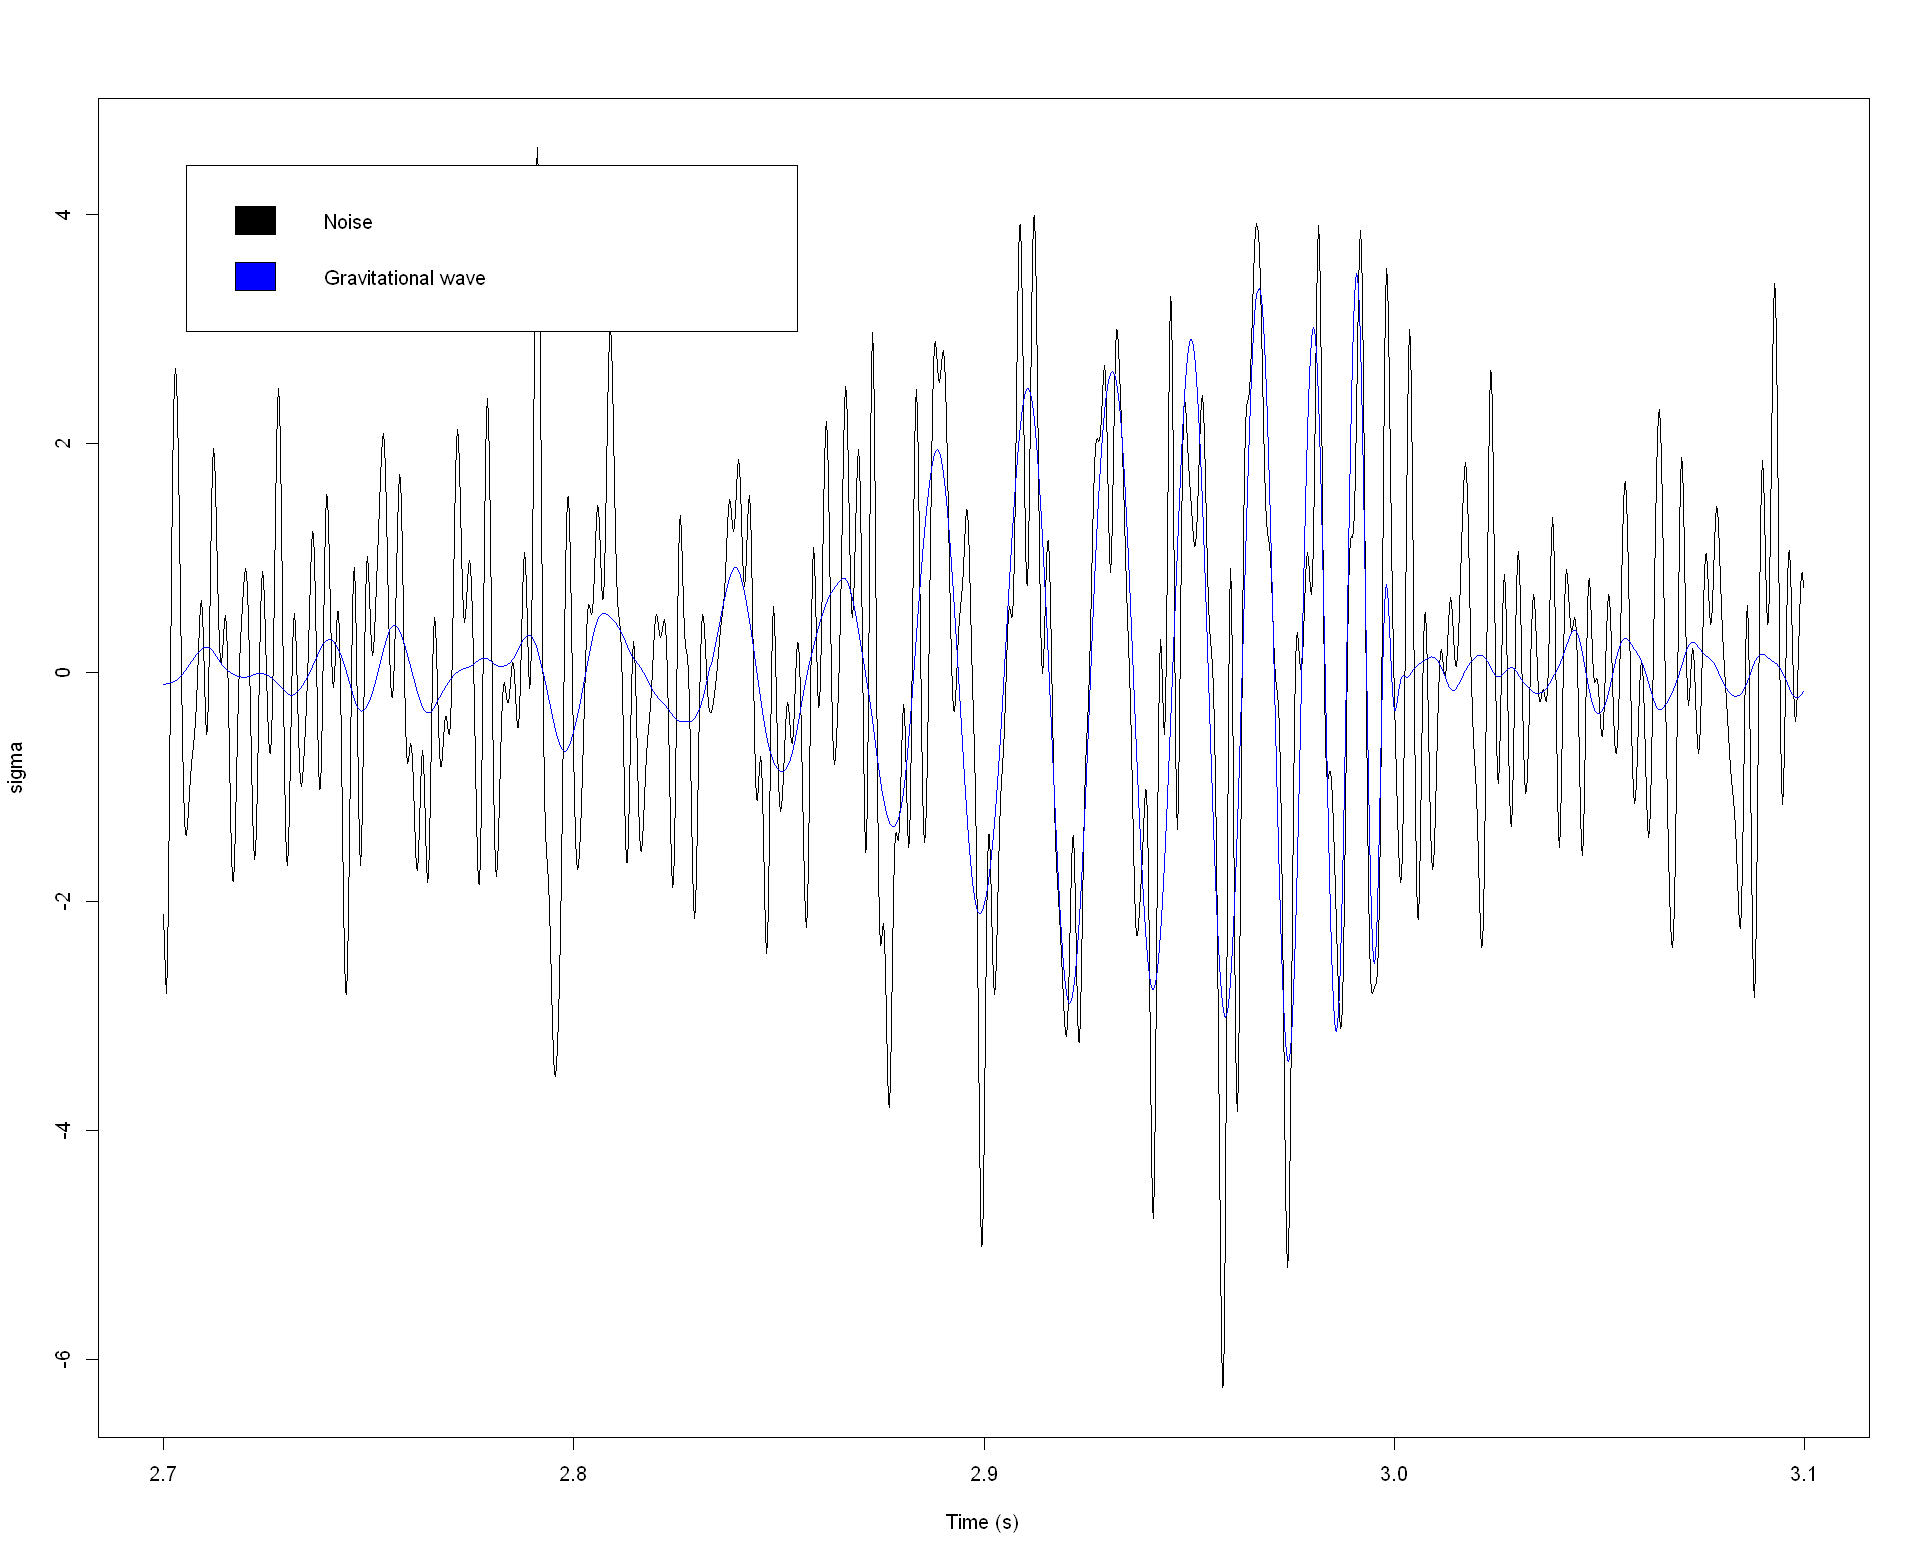

In [483]:
t1 <- 500
t2 <- 504
noise_series <- time_s2[(fs*t1):(fs*t2-1)]

times <- seq(0,4,length.out=length(noise_series))

sim_params <- c(3.0 , 5*10^(-26) , 28.6 , 3.14 )

simulated_wave <- waveform1(times,sim_params[3],sim_params[2],sim_params[3],t0 = sim_params[1])
signal <- noise_series + simulated_wave

white_signal <- Re(fft(whitener2(signal*window,sqrt(c(PSD_pow,rev(PSD_pow))),1/4096),inverse=T))
white_signal <- bandpass(white_signal,c(35,350),fs)
time_mask <- times>2.7 & times<3.1

options(repr.plot.width = 16 ,repr.plot.heigth=6)


plot(times[time_mask],white_signal[time_mask],type='l',ylab='sigma',xlab='Time (s)')

white_signal <- Re(fft(whitener2(simulated_wave*window,sqrt(c(PSD_pow,rev(PSD_pow))),1/4096),inverse=T))
white_signal <- bandpass(white_signal,c(35,350),fs)
#sim_wave_bndpss <- bandpass(simulated_wave,c(35,350),fs)
lines(times[time_mask],white_signal[time_mask],col='blue')#[(4096*3-1000):(4096*3+500)],type='l')

legend('topleft',inset = 0.05,c('Noise','Gravitational wave'),fill = c('black','blue'))



In [ ]:
thetaInit <- c(3.1,10^{-26},40,1.14) 

sampleCov <- diag(c(0.01,10^{-26},3,1)^2)

all_samp <- metrop(func=log_likel_real2,thetaInit = thetaInit,
                   Nburnin=1e4 , Nsamp= 1e5 , sampleCov = sampleCov, verbose = 1e3
                   ,obsdata=signal,PSD_pow=PSD_pow,PSD_freq = PSD$frequency,
                   priors=priors)



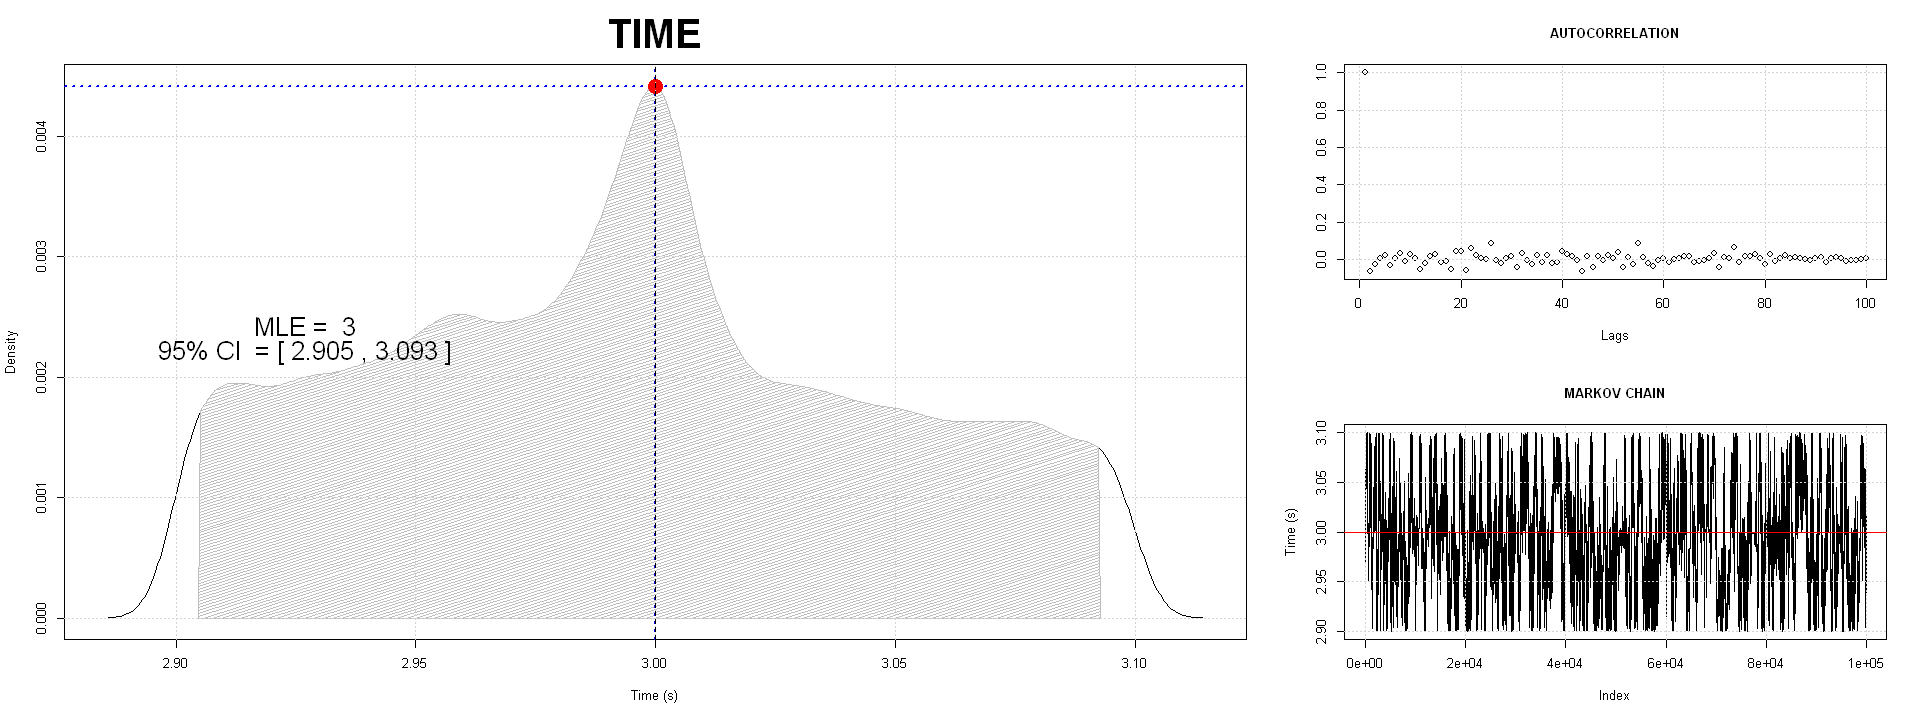

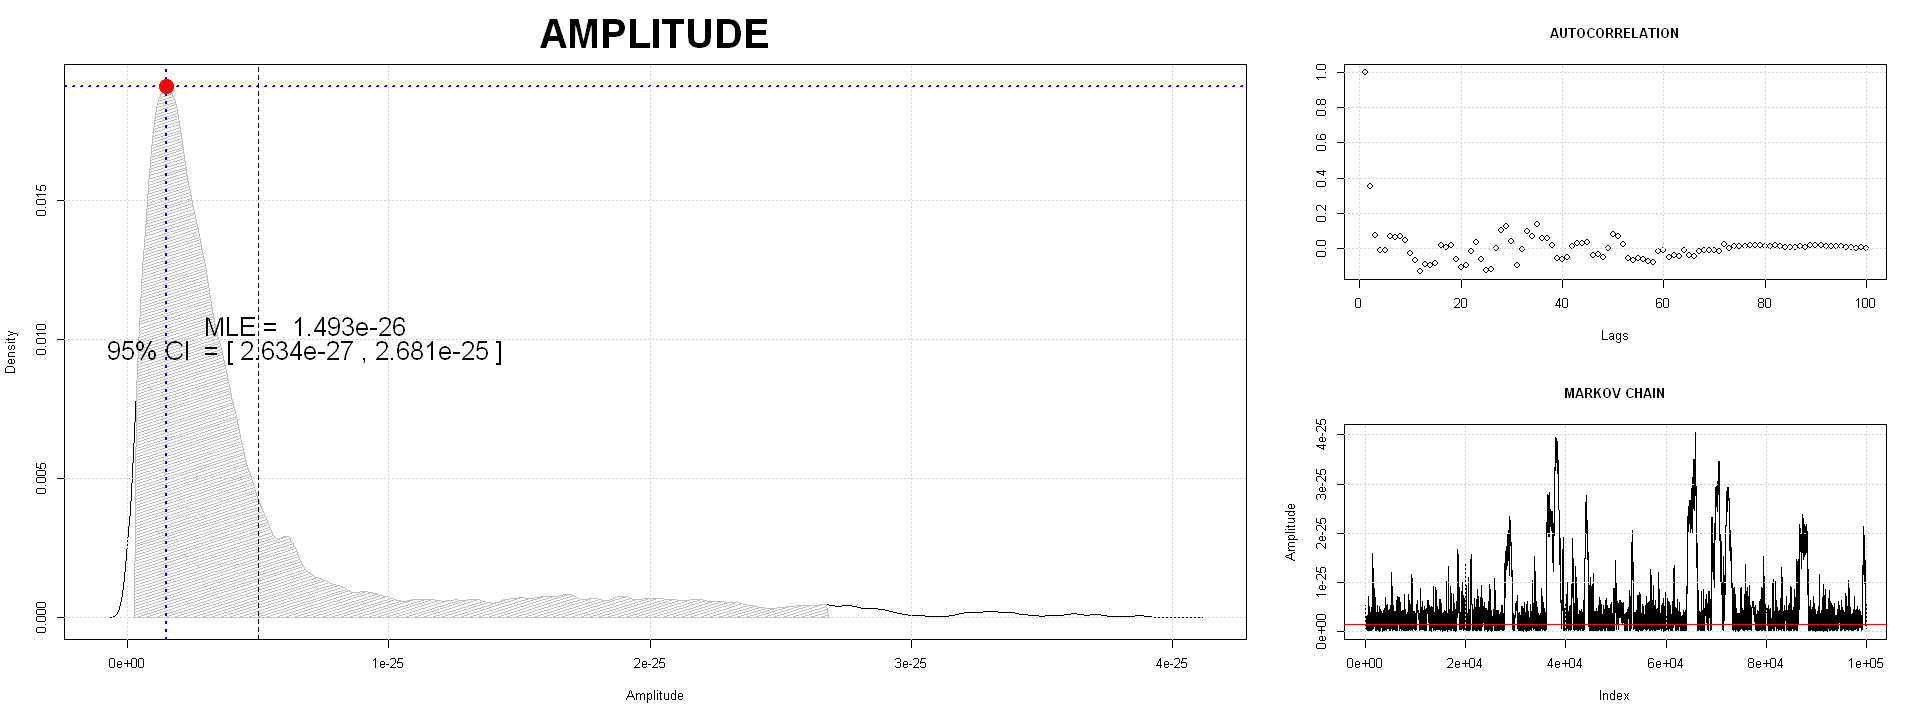

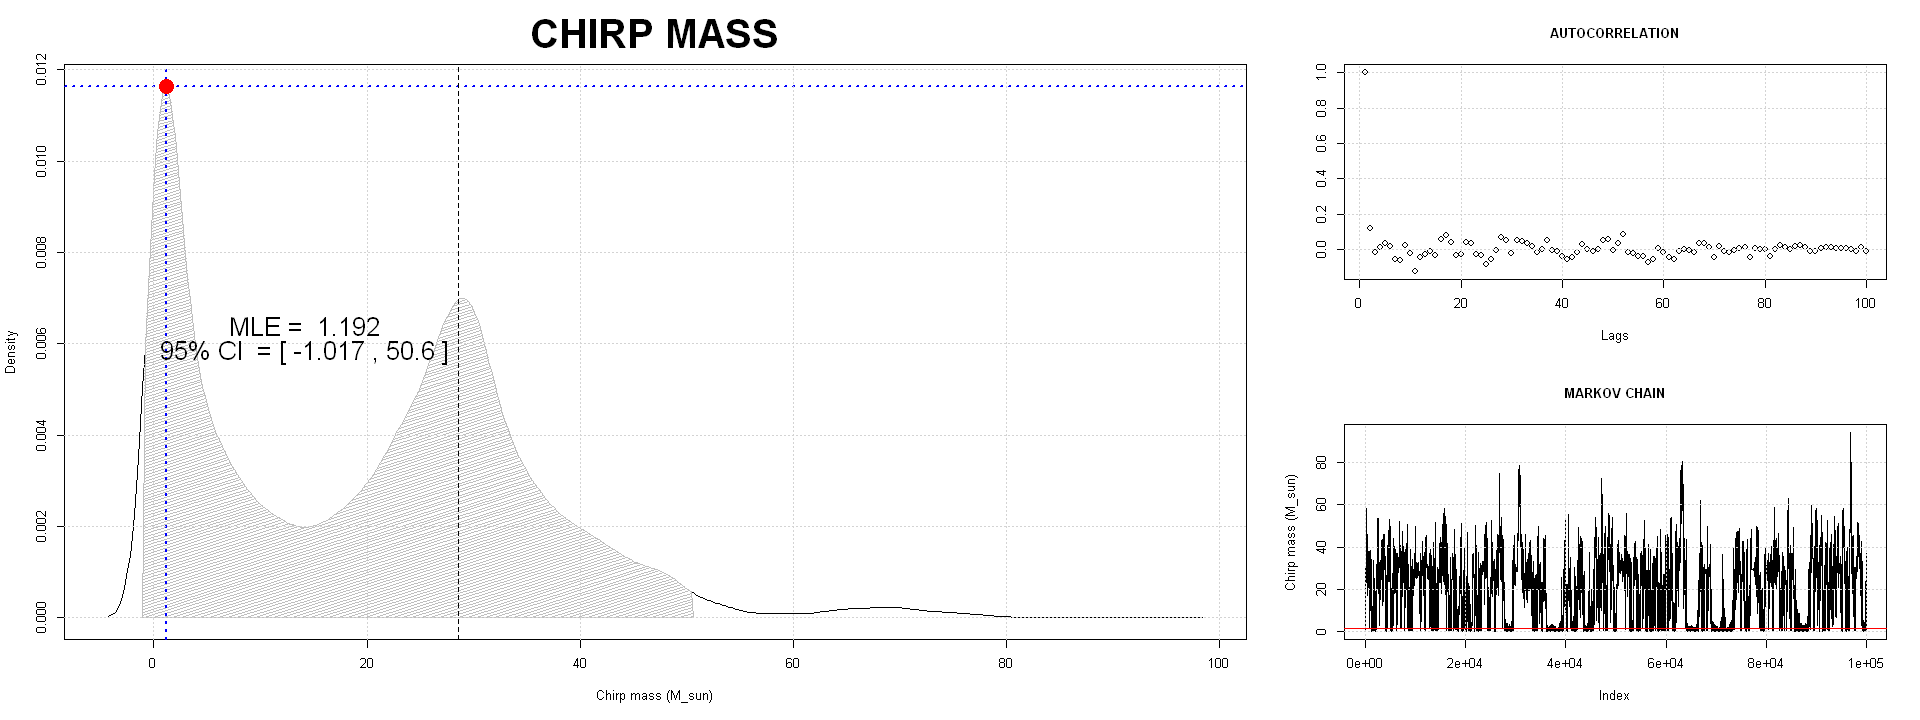

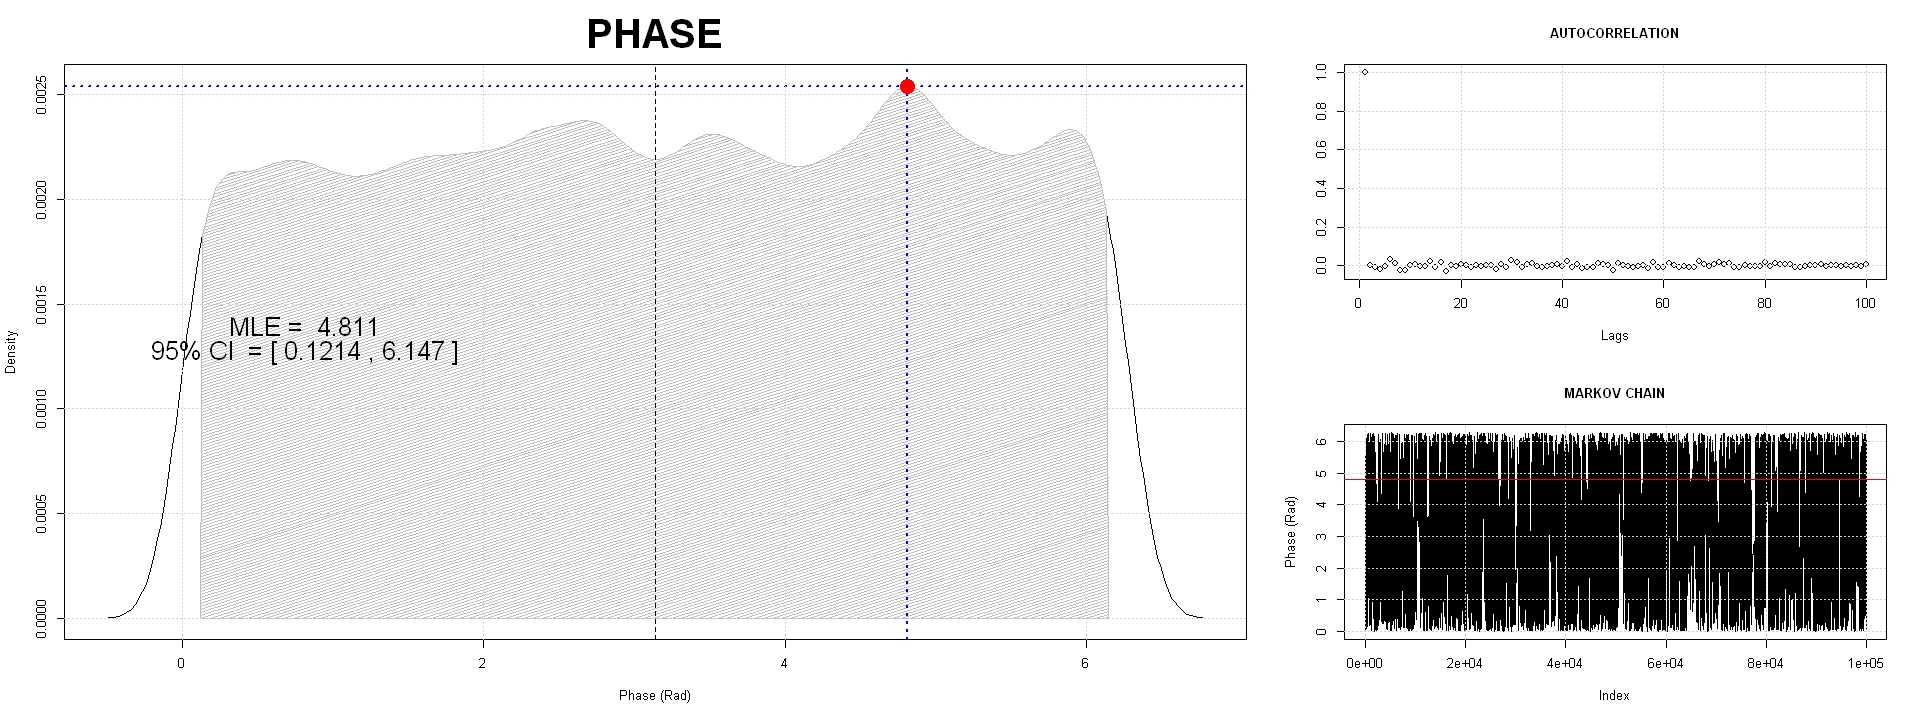

In [503]:
options(repr.plot.width=16, repr.plot.height=6)
for (i in 3:6){plott(i)}

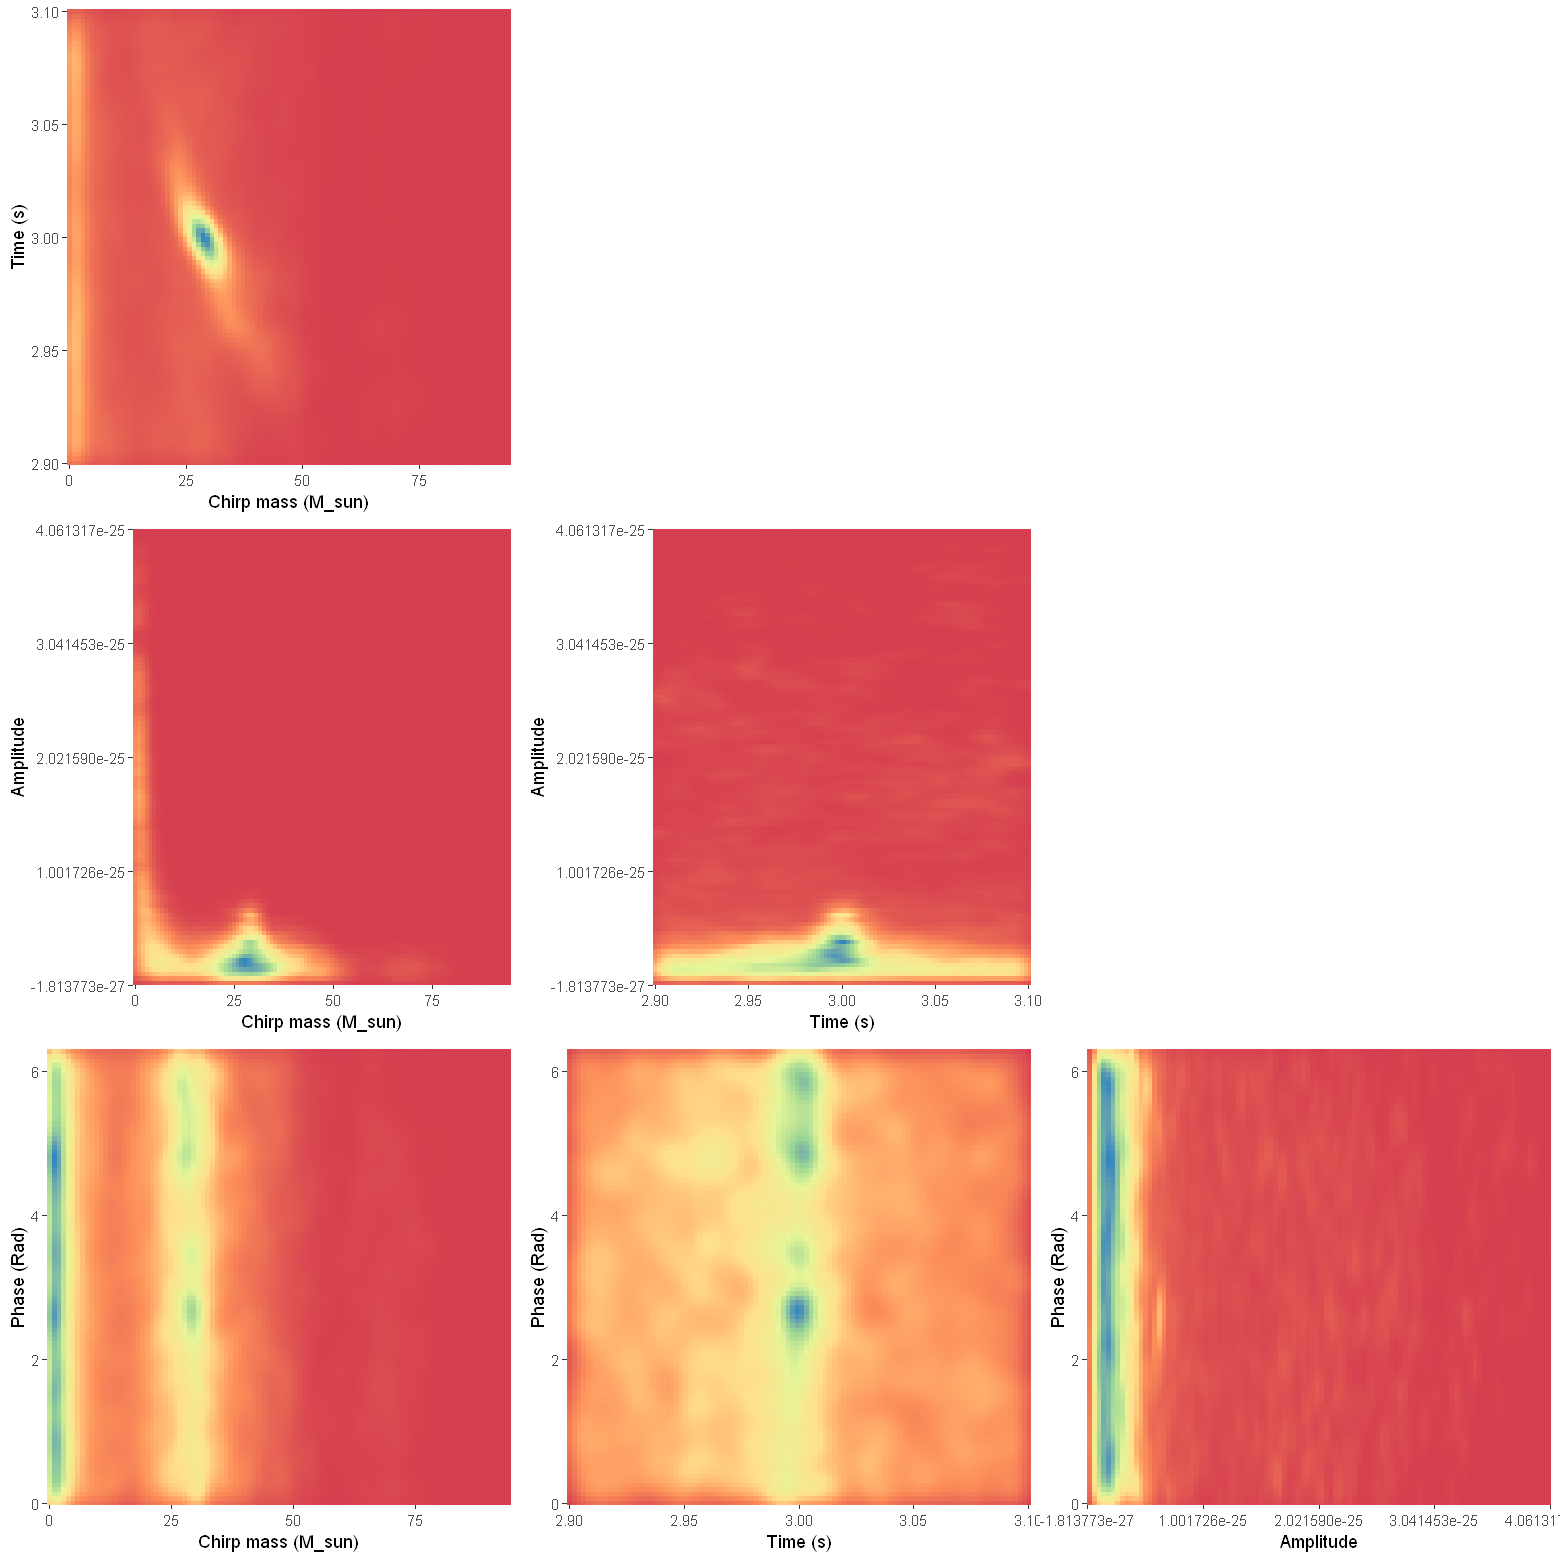

In [504]:
p1<-plot3(5,3)
p2<-plot3(5,4)
p3<-plot3(5,6)
p4<-plot3(3,4)
p5<-plot3(3,6)
p6<-plot3(4,6)

options(repr.plot.width=13, repr.plot.height=13)
p_area <- matrix(c(1,1,NA,NA,NA,NA,2,2,4,4,NA,NA,3,3,5,5,6,6),nrow=3,ncol=6,byrow = TRUE)
grid.arrange(p1,p2,p3,p4,p5,p6,layout_matrix=p_area)